# Interpolation Techniques

By Conor Simmons, Deanne Apke, Nick Lumiere, Cathleen Samson  

Github Link: https://github.com/nlumiere/Interpolation-Techniques  

## Problem Statement

We investigated how 4 different spatial interpolation techniques (Spline, Inverse Distance Weighted, Radial Basis, Kriging) with varying sample sizes would perform on our synthetic example below to recover a coherent smooth valley. 
$$ f(x,y) = -e^{{-(y-sinx)}^2}$$

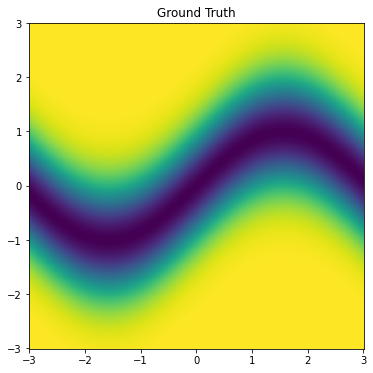

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from photutils.utils import ShepardIDWInterpolator as idw
from scipy.interpolate import Rbf
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import time
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# synthetic example
def f(x, y):
    return -np.exp(-(y-np.sin(x))**2)

# create ground truth grid
x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# color mesh map for ground truth
plt.figure(figsize=(6,6))
plt.pcolormesh(X, Y, Z, shading='auto')
plt.title('Ground Truth')
plt.show()

## Spline

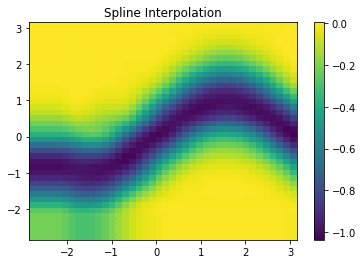

In [2]:
x_edges, y_edges = np.mgrid[-3:3:11j, -3:3:11j]
x = x_edges[:-1, :-1] + np.diff(x_edges[:2, 0])[0]*1.5
y = y_edges[:-1, :-1] + np.diff(y_edges[0, :2])[0] *1.5
z = f(x,y)
xnew_edges, ynew_edges = np.mgrid[-3:3:41j, -3:3:41j]
xnew = xnew_edges[:-1, :-1] + np.diff(xnew_edges[:2, 0])[0] *1.5
ynew = ynew_edges[:-1, :-1] + np.diff(ynew_edges[0, :2])[0] *1.5
tck = interp.bisplrep(x, y, z, s=0)
znew = interp.bisplev(xnew[:,0], ynew[0,:], tck)
plt.pcolormesh(xnew, ynew, znew, shading='auto')
plt.title('Spline Interpolation')
plt.colorbar()
plt.show()

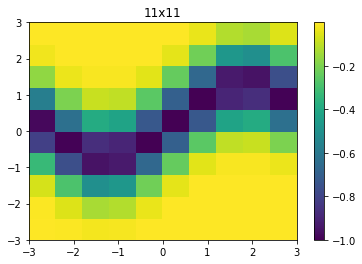

In [3]:
z_test = np.zeros((11, 11))
for i in range(11):
    for j in range(11):
        z_test[i][j] = f(x_edges[i][j], y_edges[i][j])
        

# test_arr = np.asarray([[1,2,3],[4,5,6],[7,8,9]])

def instantiate(arr2da, arr2db):
    for i in range(len(arr2da)):
        for j in range(len(arr2da[0])):
            arr2db[i*2][j*2] = arr2da[i][j]
    return arr2db
        
def increase_density(arr2d):
    sizeX = len(arr2d)
    sizeY = len(arr2d[0])
    newX = (sizeX-1)*2 + 1
    newY = (sizeY-1)*2 + 1
    arr2d_dense = np.zeros((newX, newY))
    arr2d_dense = instantiate(arr2d, arr2d_dense)
    
    for i in range(sizeX - 1):
        for j in range(sizeY - 1):
            arr2d_dense[i*2 + 1][j*2] = (arr2d_dense[i*2][j*2] + arr2d_dense[(i+1)*2][j*2])/2
            arr2d_dense[i*2][j*2 + 1] = (arr2d_dense[i*2][j*2] + arr2d_dense[i*2][(j+1)*2])/2
            
#     final row (on bottom) of matrix
    for i in range(sizeX - 1):
        arr2d_dense[i*2 + 1][newY-1] = (arr2d_dense[i*2][newY-1] + arr2d_dense[i*2 + 2][newY-1])/2
#     final column (on far-right side) of matrix
    for j in range(sizeY - 1):
        arr2d_dense[newX-1][j*2 + 1] = (arr2d_dense[newX-1][j*2] + arr2d_dense[newX-1][j*2 + 2])/2

#     centers of localized expansion
    for i in range(sizeX - 1):
        for j in range(sizeY - 1):
            arr2d_dense[i*2 + 1][j*2 + 1] = (arr2d_dense[i*2][j*2] + arr2d_dense[i*2+1][j*2] + arr2d_dense[i*2 + 2][j*2] + arr2d_dense[i*2][j*2 + 1] + arr2d_dense[i*2 + 2][j*2 + 1] + arr2d_dense[i*2][j*2 + 2] + arr2d_dense[i*2 + 1][j*2 + 2] + arr2d_dense[i*2 + 2][j*2 + 2])/8
    
    return arr2d_dense
        
plt.pcolormesh(x_edges, y_edges, z_test)
plt.colorbar()
plt.title('11x11')
plt.show()

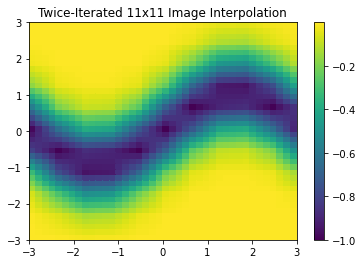

In [4]:
a = increase_density(x_edges)
b = increase_density(y_edges)
c = increase_density(z_test)
z_naivedense = increase_density(c)

plt.pcolormesh(xnew_edges, ynew_edges, z_naivedense)
plt.colorbar()
plt.title('Twice-Iterated 11x11 Image Interpolation')
plt.show()

In [5]:
x = np.linspace(-3, 3, 41)
y = np.linspace(-3, 3, 41)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# I throw out the last row and column because not all these matrices are exactly the same size
# I also throw out the first sqrt(m) columns because of the error in the spline method discussed above
mag = 0
obs_mag_spline = 0
obs_mag_jank = 0
i = 7
while(i < len(Z)-1):
    for j in range(len(Z[0])-1):
        mag += Z[i][j]
        obs_mag_spline += znew[i][j]
        obs_mag_jank += z_naivedense[i][j]
    i += 1
        
spline_error = np.abs((obs_mag_spline-mag)/mag)
jank_error = np.abs((obs_mag_jank-mag)/mag)
print("Spline error for 11x11: ", spline_error)
print("Averaging error for 11x11: ", jank_error)

Spline error for 11x11:  0.14669096333622816
Averaging error for 11x11:  0.16053158342040574


Both of these methods have notable drawbacks, in that the input data needs to be well-organized and relatively complete. It will not work like some interpolation methods that allow for randomly selected datapoints from all over the surface of a function. 

Overall, Spline interpolation (with the exception of the first 7ish columns of each output) marginally outperformed a crude and naive averaging function, which is to be expected for a sample curve such as the one used for this project. Given a more complex curve that has rapid topology fluxuations, I would expect the naive approach to underperform, while the spline approach would work comparitively better. This is because the spline interpolation method does not just take the values of the points given, but also takes into account the derivative, second derivative, and even third derivative in order to more accurately compute unknown values.

The advantages of the spline approach is that with a relatively complete dataset, one can more accurately account for fluxuations on a surface than a variety of other methods.
However, the drawbacks of the spline approach are arguably even more clear: It requires much more well-organized input data that if gathered in practice would be much more time and resource intensive.

## Inverse Distance Weighting (IDW)

In [6]:
# create ground truth grid
x = np.linspace(-3, 3, 1000)
y = np.linspace(-3, 3, 1000)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

IDW interpolation is based on the assumption that things that are close to each other are more alike than those far apart. This assumption is known as **spatial autocorrelation**. To predict an unknown value, IDW uses measured values surrounding it, having more weight on closer points than farther points. IDW uses a power p value to determine what weight to assign to that value based on distance. A high p value means only the immediate surrounding points will influence the prediction.

$$ \omega_i = \frac{1}{d(x, x_i)^{p} +r} $$
$x = $ interpolated point  
$x_i =$ known point  
$d = $ distance from known to unknown  
$p =$ power  
$r = $ regularization parameter  


![alt text](idw-graph.png "Title")

Advantages  
- Can estimate extreme changes (cliffs, fault lines)
- Dense evenly space points are well interpolated 

Disadvantages  
- Can't estimate above maximum or below minimum values 
- Sensitive to outliers
- Not very good for peaks or mountainous areas 

In [7]:
def run_IDW(n):
    x = np.linspace(-3, 3, 50000)
    y = np.linspace(-3, 3, 50000)
    sample_x = x[np.random.choice(len(x), size=n, replace=False)]
    sample_y = y[np.random.choice(len(y), size=n, replace=False)]
    sample_z = f(sample_x, sample_y)
    pos = np.vstack((sample_x, sample_y)).T
    inputx = np.linspace(-3, 3, 1000)
    inputy = np.linspace(-3, 3, 1000)
    X1, Y1 = np.meshgrid(inputx, inputy)
    Z1 = []
    t0 = time.time()
    f_predict = idw(pos, sample_z)
    for i in range(len(X1)):
        xrow = X1[i]
        yrow = Y1[i]
        row_grid = np.vstack((xrow, yrow)).T
        z_row = f_predict(row_grid)
        Z1.append(z_row)
    t1 = time.time()
    return Z1, t1-t0

def calculate_err(Z_predict):
    return np.linalg.norm(np.abs(np.subtract(Z, Z_predict)))

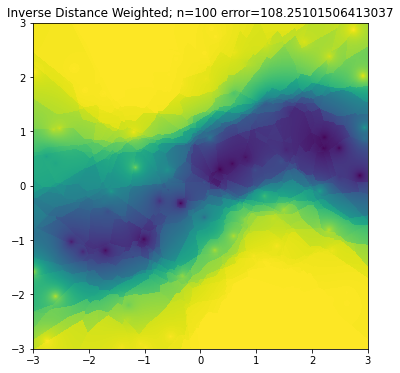

In [8]:
inputx = np.linspace(-3, 3, 1000)
inputy = np.linspace(-3, 3, 1000)
X1, Y1 = np.meshgrid(inputx, inputy)
Z_predict, _ = run_IDW(100)
err = calculate_err(Z_predict)
plt.figure(figsize=(6,6))
plt.pcolormesh(X1, Y1, Z_predict, shading='auto')
plt.title(f'Inverse Distance Weighted; n=100 error={err}')
plt.show()

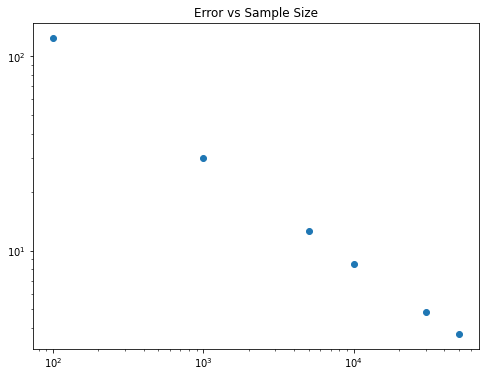

In [9]:
x = np.linspace(-3, 3, 50000)
y = np.linspace(-3, 3, 50000)
sample_sizes = [100, 1000, 5000, 10000, 30000, 50000]
errors = []
times = []
for size in sample_sizes:
    Z_predict, _ = run_IDW(size)
    errors.append(calculate_err(Z_predict))
plt.figure(figsize=(8,6))
plt.scatter(sample_sizes, errors)
plt.title('Error vs Sample Size')
plt.xscale('log')
plt.yscale('log')
plt.show()

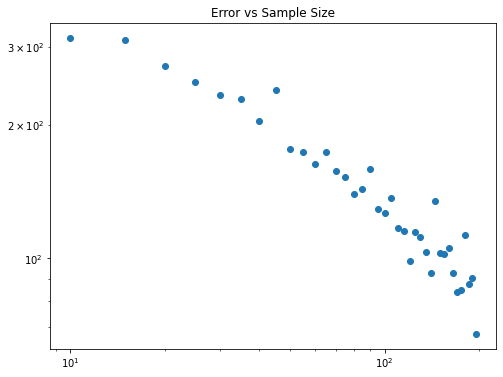

In [10]:
x = np.linspace(-3, 3, 50000)
y = np.linspace(-3, 3, 50000)
sample_sizes = np.arange(10, 200, 5)
IDW_errors = []
IDW_times = []
for size in sample_sizes:
    Z_predict, t = run_IDW(size)
    IDW_errors.append(calculate_err(Z_predict))
    IDW_times.append(t)
plt.figure(figsize=(8,6))
plt.scatter(sample_sizes, IDW_errors)
plt.title('Error vs Sample Size')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Radial

In [11]:
# create ground truth grid
x = np.linspace(-3, 3, 1000)
y = np.linspace(-3, 3, 1000)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

#### Radial Basis Functions

The radial basis functions are functions that depend on $r$, the distance to a point from some other point. 

There are some different options as to what radial functions to use in `scipy.interpolate.Rbf` but the default is multiquadric, which is defined as

$$\varphi(r) = \sqrt{1+(\epsilon r)^2}$$

where $\epsilon$ is an approximate average distance between data points. Let $R$ be the distance matrix using Euclidean distance between all nodes in the input data. Then

$$A = \varphi(R)$$

$A$ takes the form

![alt text](distance_mat.svg)

`scipy` solves for the coefficients $c$ using LU factorization on this system

$$Ac=z$$

where $z$ is the function evaluated at the input data. 

You can then interpolate by constructing a new distance matrix, $B$, which is $k \times i$ (where $k$ is the number of new points to evaluate and $i$ is the number of input points) and computing

$$Bc = \hat{z}$$

This method is pretty accurate, but more on the expensive side.

In [12]:
def calc_rbf_err(X, Y, Z, n):
    x = np.linspace(-3, 3, 50000)
    y = np.linspace(-3, 3, 50000)
    sample_x = x[np.random.choice(len(x), size=n, replace=False)]
    sample_y = y[np.random.choice(len(y), size=n, replace=False)]
    sample_z = f(sample_x, sample_y)
    
    t0 = time.time()
    rbfi = Rbf(sample_x, sample_y, sample_z)
    Zhat = rbfi(X, Y)
    t1 = time.time()
    err = np.linalg.norm(np.abs(np.subtract(Zhat, Z)))
    return Zhat, t1-t0, err

Zhat, _, err = calc_rbf_err(X, Y, Z, 100)

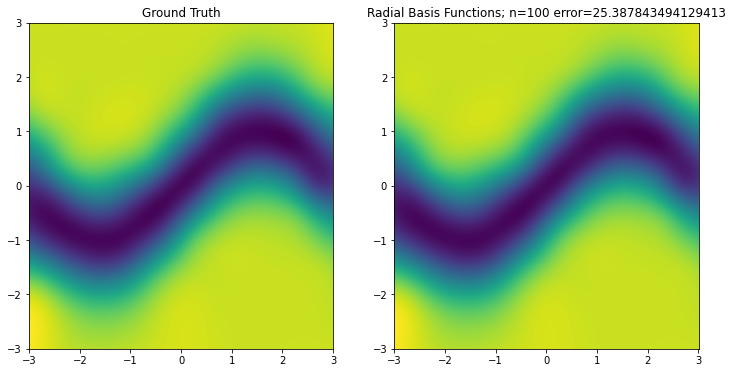

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].pcolormesh(X, Y, Zhat, shading='auto')
ax[0].set_title('Ground Truth')
ax[1].pcolormesh(X, Y, Zhat, shading='auto')
ax[1].set_title(f'Radial Basis Functions; n=100 error={err}')
plt.show()

In [14]:
sample_sizes = np.arange(10, 200, 5)
RBF_errors = []
RBF_times = []
for size in sample_sizes:
    _, t, err = calc_rbf_err(X, Y, Z, size)
    RBF_errors.append(err)
    RBF_times.append(t)

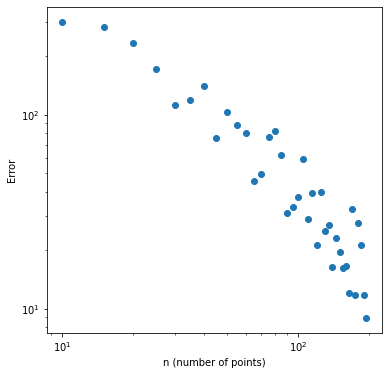

In [15]:
plt.figure(figsize=(6,6))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n (number of points)')
plt.ylabel('Error')
plt.scatter(sample_sizes, RBF_errors)
plt.show()

## Kriging

In [16]:
# create ground truth grid
x = np.linspace(-3, 3, 500)
y = np.linspace(-3, 3, 500)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

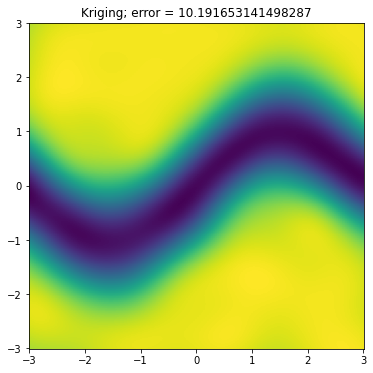

In [17]:
#Now we'll run a sample kriging, taking in 100 random points from the 500
n = 100 
sample_x = x[np.random.choice(len(x), size=n, replace=False)]
sample_y = y[np.random.choice(len(y), size=n, replace=False)]
sample_z = f(sample_x, sample_y)

# Run ordinary kriging - with a gaussian variogram model
OK = OrdinaryKriging(sample_x, sample_y, sample_z, variogram_model="gaussian", enable_plotting=False)
#Now execute kriging to get the predicted values for areas with no data
kriging_z_values, variance = OK.execute('grid', x, y)

#Function to get the error
def get_error(predicted_values, actual_values):
    return np.linalg.norm(np.abs(np.subtract(predicted_values, actual_values)))


#Now let's plot and see how the kriging did
plt.figure(figsize=(6,6))
plt.pcolormesh(X, Y, kriging_z_values, shading='auto')
plt.title(f'Kriging; error = {get_error(kriging_z_values, Z)}')
plt.show()

In [18]:
# Let's up that dataset size to really push it
x = np.linspace(-3, 3, 1000)
y = np.linspace(-3, 3, 1000)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Now we create a function to run kriging with any n number of samples from the data, returning the error
def get_kriging_error(n):
    sample_x = x[np.random.choice(len(x), size=n, replace=False)]
    sample_y = y[np.random.choice(len(y), size=n, replace=False)]
    sample_z = f(sample_x, sample_y)
    
    # Run ordinary kriging then execute with full dataset to get predictions
    t0 = time.time()
    OK = OrdinaryKriging(sample_x, sample_y, sample_z, variogram_model="gaussian", enable_plotting=False)
    kriging_z_values, variance = OK.execute('grid', x, y)
    t1 = time.time()
    
    #Now get the error from kriging and return it
    return get_error(kriging_z_values, Z), t1-t0

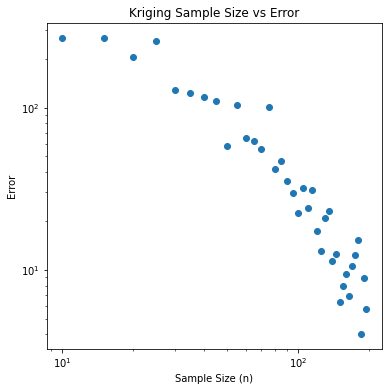

In [19]:
#List of sample sizes to try out
sample_sizes_alt = np.arange(10, 200, 5)
Krig_errors = []
Krig_times = []
for sample in sample_sizes_alt:
    err, t = get_kriging_error(sample)
    Krig_errors.append(err)
    Krig_times.append(t)

# Let's plot out those errors to see how it did
plt.figure(figsize=(6,6))
plt.scatter(sample_sizes_alt, Krig_errors)
plt.xlabel("Sample Size (n)")
plt.ylabel("Error")
plt.title("Kriging Sample Size vs Error")
plt.xscale('log')
plt.yscale('log')
plt.show()

Kriging performs about as well as Radial Basis but with one noticeable drawback, at least with the PyKrige package. That drawback is in memory usage. The default behavior of the PyKrige package is to solve the entire kriging problem at once in a single vectorized operation - which with either large grids of data or large sample sizes will easily eat up the entirety of RAM. This can be changed, however, by setting the optional parameter backend in the execute() function to 'loop' RAM can be saved - by sacrificing a lot more time for the problem to run.

So there's a definite memory usage vs time trade-off when it comes to running large datasets with kriging - but kriging itself provides a rather good interpolation of the data with smaller sample data, 

## Direct Comparison

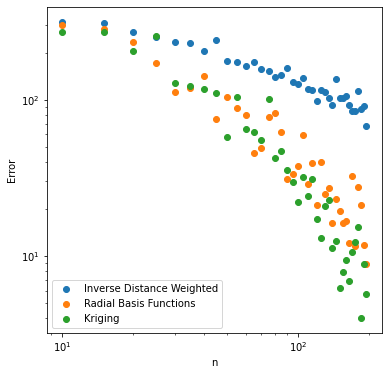

In [20]:
plt.figure(figsize=(6,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(sample_sizes, IDW_errors, label='Inverse Distance Weighted')
plt.scatter(sample_sizes, RBF_errors, label='Radial Basis Functions')
plt.scatter(sample_sizes_alt, Krig_errors, label='Kriging')
plt.xlabel('n')
plt.ylabel('Error')
plt.legend()
plt.show()

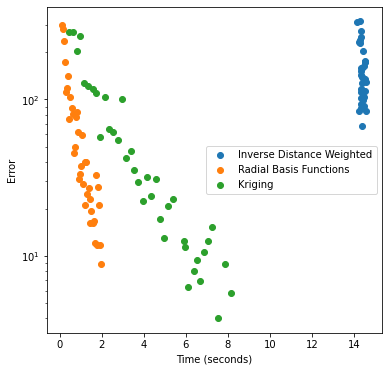

In [21]:
plt.figure(figsize=(6,6))
plt.yscale('log')
plt.scatter(IDW_times, IDW_errors, label='Inverse Distance Weighted')
plt.scatter(RBF_times, RBF_errors, label='Radial Basis Functions')
plt.scatter(Krig_times, Krig_errors, label='Kriging')
plt.xlabel('Time (seconds)')
plt.ylabel('Error')
plt.legend()
plt.show()

## Next Steps

* Plot with a broader scope of functions, including those with greater z-axis fluxuation. This will better determine deep-fitting algorithms from naive ones.
* See if we can get real DM data to test interpolation techniques on. 
* Dive deeper into strange looking artifacts: e.g. -x/-y quadrant of spline. 

To see our github repo: https://github.com/nlumiere/Interpolation-Techniques/settings/access